In [1]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.stats import mannwhitneyu
from collections import OrderedDict

# all the correction approaches
all_methods = [
    'note_1_text',
    'note_2_text',
    'correction_response (ours, time reference: high-qual note)',
    'correction_response (ours, time reference: avg-qual note)',
    'correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)',
    'correction_response (ours removing retrieval)',
    'correction_response (ours removing image)',
    'correction_response (ours, time reference: tweet)'
]

# all the annotations who completed the tasks
all_users = [  
    'group1_user1',
    'group1_user2',
    'group2_user1',
    'group2_user2',  
    'group3_user1',
    'group3_user2',
    'group4_user1',
    'group4_user2',
    'group5_user1',
    'group5_user2'
]

In [2]:
path = '../data/'

# process annotations
df_eval = pd.read_csv(path + 'Q9-overall_quality.csv', dtype=str)
phase_1_post_ids = ['100', '107', '110', '114', '118', '119', '124', '128', '142', '144', '149', '152', '163', '173', '184']
df_eval = df_eval[~df_eval['post_id'].isin(phase_1_post_ids)]

# process responses
postId_tweetId = pd.read_csv(path + 'tweetid_postid.csv', dtype=str)
df_resp_mm = pd.read_csv(path + 'responses_multimodal.csv', dtype=str)
df_resp_mm = df_resp_mm.merge(postId_tweetId, on='tweet_id', how='left')
df_resp_um = pd.read_csv(path + 'responses_unimodal.csv', dtype=str)
df_resp_um = df_resp_um.merge(postId_tweetId, on='tweet_id', how='left')
df_resp = pd.concat((df_resp_mm, df_resp_um))
df_resp = df_resp.fillna('nan')

# get the post ids whose responses were evaluated by one participant only
userName_tweetIds = pd.read_csv(path + 'username_tweetids.csv', dtype=str)
userName_tweetIds = dict(zip(userName_tweetIds['username'], [tweet_ids.split(';') for tweet_ids in userName_tweetIds['tweet_ids']]))

tweetId_postId = pd.read_csv(path + 'tweetid_postid.csv', dtype=str)
tweetId_postId = dict(zip(tweetId_postId['tweet_id'], tweetId_postId['post_id']))

userName_postIds = {}
for username, tweet_ids in userName_tweetIds.items():
    if username in all_users:
        userName_postIds[username] = [tweetId_postId[tweet_id] for tweet_id in tweet_ids]

userName_postIds_2 = {}
for group_num in range(1, 6):
    u0, u1 = 'group'+str(group_num)+'_user1', 'group'+str(group_num)+'_user2'
    post_ids_u0 = set(userName_postIds[u0])
    post_ids_u1 = set(userName_postIds[u1])
    post_ids_u0_unique = post_ids_u0.difference(post_ids_u1)
    post_ids_u1_unique = post_ids_u1.difference(post_ids_u0)

    userName_postIds_2[u0] = list(post_ids_u0_unique)
    userName_postIds_2[u1] = list(post_ids_u1_unique)
    
# get the labels for each approach
methods, scores = [], []
for user in all_users:
    post_ids = df_eval[df_eval['username'] == user]['post_id'].unique()
    for post_id in post_ids:
        method_label = {}

        df = df_eval[(df_eval['username'] == user) & (df_eval['post_id'] == post_id)]

        methods_included = df['response_type'].unique()
        for method in methods_included:
            labels = list(df[df['response_type'] == method]['label'])

            if len(labels) != 1:
                print('ERROR')
            else:
                methods.append(method)
                scores.append(labels[0])
                if post_id in userName_postIds_2[user]:
                    methods.append(method)
                    scores.append(labels[0])
                method_label[method] = labels[0]

        methods_excluded = set(all_methods).difference(set(methods_included))
        for method in methods_excluded:
            responses = list(df_resp[df_resp['post_id'] == post_id][method])

            if len(responses) != 1:
                print('ERROR')
            else:
                if responses[0] == 'nan':
                    continue
                elif responses[0] == '~':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours, time reference: high-qual note)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours, time reference: high-qual note)'])
                elif responses[0] == '|||':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours, time reference: avg-qual note)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours, time reference: avg-qual note)'])
                elif responses[0] == '///':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(
                            method_label['correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)'])
                elif responses[0] == '*':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing retrieval)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours removing retrieval)'])
                elif responses[0] == '$':
                    methods.append(method)
                    scores.append(method_label['correction_response (ours removing image)'])
                    if post_id in userName_postIds_2[user]:
                        methods.append(method)
                        scores.append(method_label['correction_response (ours removing image)'])

df = pd.DataFrame({
    'Method': methods,
    'Quality': scores
})

MUSE, n = 232
GPT-4, n = 232
Laypeople (high), n = 232
Laypeople (avg), n = 230

5.176086956521739
6.273706896551724
5.926724137931035
8.125


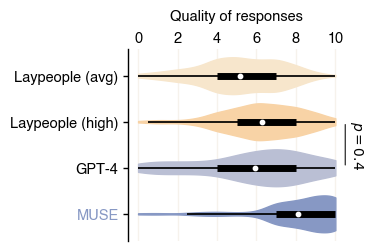

In [3]:
# plot setup 
plt.style.use('default')
plt.rcParams['font.family'] = 'Helvetica'

matplotlib.rcParams['font.size'] = 10.5

target_methods_mapping = {
    'correction_response (ours, time reference: tweet)': 'MUSE',
    'correction_response (ours removing {retrieval+image}, i.e., vanilla gpt-4)': 'GPT-4',
    'note_1_text': 'Laypeople (high)',
    'note_2_text': 'Laypeople (avg)'
}

method_color = {
    'Laypeople (avg)': '#F7E6CC',
    'Laypeople (high)': '#F8D3A6',
    'GPT-4': '#BABFD4',
    'MUSE': '#8798C4'
}

dict_plot = {}
for method in target_methods_mapping.keys():
    scores = list(df[df['Method'] == method]['Quality'])
    scores = [int(s) for s in scores]
    print(target_methods_mapping[method] + ', n =', int(len(scores)/2))
    dict_plot[target_methods_mapping[method]] = scores
dict_plot = OrderedDict({method: scores for method, scores in dict_plot.items()})

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

fig, ax = plt.subplots(figsize=(2.8, 2.5))
violins = ax.violinplot(list(dict_plot.values()), widths=0.8, showmeans=False, showmedians=False, showextrema=False, vert=False)

i = 0
for violin in violins['bodies']:
    violin.set_facecolor(method_color[list(dict_plot.keys())[i]])
    violin.set_edgecolor(method_color[list(dict_plot.keys())[i]])
    violin.set_linewidth(1)
    violin.set_alpha(1)
    i += 1

means = [sum(scores) / len(scores) for scores in dict_plot.values()]
for i, labels in enumerate(list(dict_plot.values())):
    quartile1, median, quartile3 = np.percentile(np.array(labels), [25, 50, 75])
    whiskers_min, whiskers_max = adjacent_values(np.sort(labels), quartile1, quartile3)

    ax.scatter(means[i], i + 1, marker='o', color='white', s=10, zorder=10)
    ax.hlines(i+1, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.hlines(i+1, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1.25)

plt.xlim([-0.5, 10.5])
plt.xticks([0, 2, 4, 6, 8, 10])
plt.xlabel('Quality of responses', x=0.5, labelpad=8)
plt.yticks(ticks=[1, 2, 3, 4], labels=list(dict_plot.keys()))
ax.xaxis.set_label_position('top')
plt.setp(ax.spines.values(), color='k', linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_tick_params(width=1)
ax.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, axis='x', pad=-1.5)
ax.set_axisbelow(True)
ax.grid(axis='x', color='#F6F2EC', linewidth=1)
plt.gca().get_yticklabels()[0].set_color('#8798C4')
plt.gca().get_yticklabels()[0].set_fontweight('bold')

ax.annotate('', xy=(10.5, 2), xytext=(10.5, 3), arrowprops=dict(arrowstyle='-', lw=0.75, color='k'))
ax.text(11.5, 2.5, r'$p=0.4$', va='center', ha='right', fontsize=10, rotation=-90)

print()
print(np.mean(dict_plot['Laypeople (avg)']))
print(np.mean(dict_plot['Laypeople (high)']))
print(np.mean(dict_plot['GPT-4']))
print(np.mean(dict_plot['MUSE']))

In [4]:
methods_pval = {}
method_pairs = [(a, b) for idx, a in enumerate(target_methods_mapping.values()) for b in
                list(target_methods_mapping.values())[idx + 1:]]
for m1, m2 in method_pairs:
    _, p = mannwhitneyu(dict_plot[m1], dict_plot[m2])
    methods_pval[(m1, m2)] = p
pprint(methods_pval)

{('GPT-4', 'Laypeople (avg)'): 2.121569059193934e-08,
 ('GPT-4', 'Laypeople (high)'): 0.3731100449220087,
 ('Laypeople (high)', 'Laypeople (avg)'): 3.6148722662099666e-15,
 ('MUSE', 'GPT-4'): 3.988600137159753e-42,
 ('MUSE', 'Laypeople (avg)'): 4.72999636497213e-81,
 ('MUSE', 'Laypeople (high)'): 2.6722815148220234e-48}
